### **STEP 1: Librerie**

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# STEP 2: Dataset personalizzato

In [3]:
from PIL import Image
from torch.utils.data import Dataset
import torch

class HybridAudioDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df['spectrogram_path'].values
        self.features = df[["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]].values.astype(np.float32)
        self.labels = df['label_encoded'].values.astype(np.int64)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        x_feat = torch.tensor(self.features[idx])
        y = torch.tensor(self.labels[idx])
        return img, x_feat, y


In [4]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/dataset/ai-mechanic-export/training"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/spectrograms/training_segmented"
OUTPUT_WAV_DIR  = "/content/drive/MyDrive/audio_segmented"
SEGMENT_DURATION = 5  # secondi

# Crea cartelle output
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)
Path(OUTPUT_WAV_DIR).mkdir(parents=True, exist_ok=True)

def save_mel_spectrogram(y, sr, output_path):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize=(0.72, 0.72))
    ax = fig.add_subplot(111)
    ax.axis('off')
    librosa.display.specshow(S_dB, sr=sr)
    plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# Elabora ogni file
audio_files = [f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")]
segment_count = 0

for fname in tqdm(audio_files, desc=" Segmentazione audio"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    try:
        y, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        samples_per_segment = int(SEGMENT_DURATION * sr)
        num_segments = int(duration // SEGMENT_DURATION)

        for i in range(num_segments):
            start_sample = i * samples_per_segment
            end_sample = start_sample + samples_per_segment
            segment = y[start_sample:end_sample]

            base_name = fname.replace(".wav", f"_seg{i}")

            # Salva PNG spettrogramma
            output_png_path = os.path.join(OUTPUT_PNG_DIR, base_name + ".png")
            save_mel_spectrogram(segment, sr, output_png_path)

            # Salva audio WAV
            output_wav_path = os.path.join(OUTPUT_WAV_DIR, base_name + ".wav")
            sf.write(output_wav_path, segment, sr)

            segment_count += 1

    except Exception as e:
        print(f"Errore su {fname}: {e}")

print(f"\nSegmenti generati: {segment_count} (immagini + audio)")

 Segmentazione audio: 100%|██████████| 34/34 [04:46<00:00,  8.43s/it]


Segmenti generati: 223 (immagini + audio)


In [5]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# === CONFIGURAZIONE ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/audio_segmented"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)

# === FUNZIONE: Verifica se un file audio è valido ===
def is_valid_audio(filepath, min_amplitude=0.01, min_duration=0.5):
    try:
        y, sr = librosa.load(filepath, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        max_amp = np.abs(y).max()
        return duration >= min_duration and max_amp >= min_amplitude
    except Exception as e:
        print(f"[Errore audio] {filepath}: {e}")
        return False

# === FUNZIONE: Crea spettrogramma mel e salva come PNG ===
def create_mel_spectrogram(audio_path, output_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        fig = plt.figure(figsize=(0.72, 0.72))
        ax = fig.add_subplot(111)
        ax.axis('off')
        librosa.display.specshow(S_dB, sr=sr)
        plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except Exception as e:
        print(f"[Errore spettrogramma] {audio_path}: {e}")

# === PROCESSO ===
audio_files = sorted([f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")])
valid_count, skipped_count = 0, 0

for fname in tqdm(audio_files, desc=" Generazione PNG validi"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    png_name = fname.replace(".wav", ".png")
    png_path = os.path.join(OUTPUT_PNG_DIR, png_name)

    if not is_valid_audio(audio_path):
        skipped_count += 1
        continue

    create_mel_spectrogram(audio_path, png_path)
    valid_count += 1

print(f"\nPNG generati: {valid_count}")
print(f"File saltati (non validi): {skipped_count}")

 Generazione PNG validi: 100%|██████████| 223/223 [00:56<00:00,  3.94it/s]


PNG generati: 98
File saltati (non validi): 125


In [6]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === CONFIG ===
csv_path = "/content/drive/MyDrive/features_combined_balanced.csv"
SPECTROGRAM_DIR = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"

df = pd.read_csv(csv_path)

records = []

# 🔁 Per ogni riga del CSV, cerca i relativi PNG segmentati
for _, row in df.iterrows():
    base_name = os.path.basename(row["audio_path"]).replace(".wav", "")
    for file in os.listdir(SPECTROGRAM_DIR):
        if file.startswith(base_name) and file.endswith(".png"):
            records.append({
                **row,
                "spectrogram_path": os.path.join(SPECTROGRAM_DIR, file)
            })

#  Crea nuovo DataFrame
df_new = pd.DataFrame(records)

#  Label encoding
le = LabelEncoder()
df_new["label_encoded"] = le.fit_transform(df_new["label"])

# Normalizza feature
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
scaler = StandardScaler()
df_new[features] = scaler.fit_transform(df_new[features])

# Salva
output_path = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
df_new.to_csv(output_path, index=False)
print(f"CSV aggiornato salvato in: {output_path}")
print(f" Righe finali: {len(df_new)}")

CSV aggiornato salvato in: /content/drive/MyDrive/features_combined_balanced_updated.csv
 Righe finali: 168


# STEP 3: Caricamento e preprocessing CSV

In [7]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Percorso dove sono i .png
SPECTROGRAM_DIR = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"

# Leggi il CSV
df = pd.read_csv("/content/drive/MyDrive/features_combined_balanced_updated.csv")

# Ottieni tutti i nomi dei file PNG esistenti nella cartella
available_pngs = set(os.listdir(SPECTROGRAM_DIR))

# Funzione: trova il PNG corrispondente a ogni file audio (se esiste almeno uno _segX.png)
def match_existing_png(audio_path):
    base = os.path.basename(audio_path).replace(".wav", "")
    matches = [f for f in available_pngs if f.startswith(base)]
    if matches:
        # Prendi il primo disponibile (oppure crea più righe se vuoi includerli tutti)
        return os.path.join(SPECTROGRAM_DIR, matches[0])
    return None

# Applica la funzione
df["spectrogram_path"] = df["audio_path"].apply(match_existing_png)

# Filtra i validi
df = df[df["spectrogram_path"].notnull()].reset_index(drop=True)

# Codifica le etichette
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Normalizza le feature
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

print(" DataFrame pronto con shape:", df.shape)
print(df.head())

 DataFrame pronto con shape: (168, 9)
                                          audio_path  \
0  /content/drive/MyDrive/ai-mechanic-export/trai...   
1  /content/drive/MyDrive/ai-mechanic-export/trai...   
2  /content/drive/MyDrive/ai-mechanic-export/trai...   
3  /content/drive/MyDrive/ai-mechanic-export/trai...   
4  /content/drive/MyDrive/ai-mechanic-export/trai...   

                                    spectrogram_path  \
0  /content/drive/MyDrive/spectrograms/training_v...   
1  /content/drive/MyDrive/spectrograms/training_v...   
2  /content/drive/MyDrive/spectrograms/training_v...   
3  /content/drive/MyDrive/spectrograms/training_v...   
4  /content/drive/MyDrive/spectrograms/training_v...   

                          label  pitch_mean  pitch_std    energy  zcr_mean  \
0  air leak engine inside cabin   -1.128317  -1.593743  2.461602 -1.342610   
1  air leak engine inside cabin   -1.128317  -1.593743  2.461602 -1.342610   
2    normal engine inside cabin   -1.127997  -1.588608

# STEP 4: Split

In [8]:
from sklearn.model_selection import train_test_split

# Split iniziale: 80% train_val, 20% test
df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

# Split secondario: 80% train, 20% val (sul restante 80%)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val['label_encoded'], random_state=42)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 107, Val: 27, Test: 34



# STEP 5: Dataset & DataLoader

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_ds = HybridAudioDataset(df_train, transform=transform)
val_ds   = HybridAudioDataset(df_val, transform=transform)
test_ds  = HybridAudioDataset(df_test, transform=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


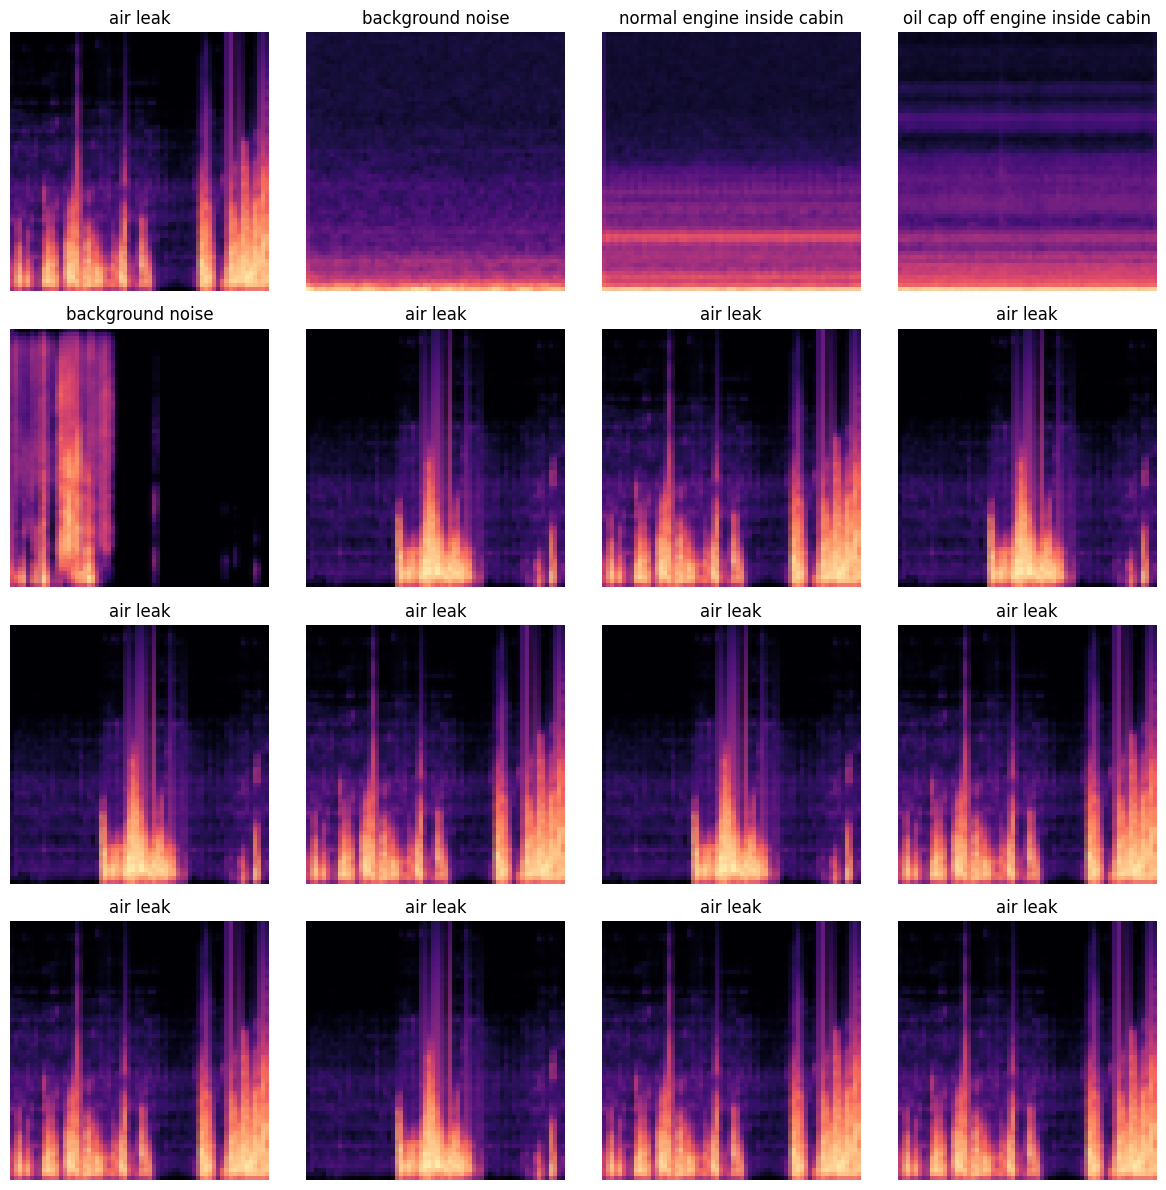

In [10]:
imgs, feats, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12)) # Adjusted figure size for 4x4 layout
for i in range(16):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    label_str = le.inverse_transform([labels[i].item()])[0]
    plt.subplot(4, 4, i+1) # Changed subplot layout to 4x4
    plt.imshow(img_np)
    plt.title(f"{label_str}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# STEP 6: CNN Ibrida

In [11]:
class HybridCNNImproved(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNImproved, self).__init__()
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(5, 32), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*8*8 + 32, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.cnn_branch(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ==== Early Stopping ====
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# STEP 7: Setup

In [13]:
print(f"label_encoded min: {df['label_encoded'].min()}, max: {df['label_encoded'].max()}")
print(f"Numero classi da LabelEncoder: {len(le.classes_)}")
print("Classi da LabelEncoder:", list(le.classes_))

label_encoded min: 0, max: 5
Numero classi da LabelEncoder: 6
Classi da LabelEncoder: ['air leak', 'air leak engine inside cabin', 'background noise', 'idling', 'normal engine inside cabin', 'oil cap off engine inside cabin']


In [14]:
# Ricorda: le.label_encoded deve avere valori da 0 a 5
model = HybridCNNImproved(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStopping(patience=8)
EPOCHS =25

# STEP 8: Training

In [15]:
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    running_train_loss, correct_train, total_train = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_acc.append(correct_train / total_train)
    train_loss.append(running_train_loss / total_train)

    # === VALIDATION ===
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in val_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc.append(correct_val / total_val)
    val_loss.append(running_val_loss / total_val)

    # === TEST ===
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc.append(correct_test / total_test)
    test_loss.append(running_test_loss / total_test)

    # === STAMPA ===
    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f} | "
          f"Test Acc: {test_acc[-1]:.2f}, Loss: {test_loss[-1]:.4f}")

    # === EARLY STOPPING ===
    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# === ULTIMA STAMPA FINALE (dopo stop) ===
print(f"\n Final Test Accuracy: {test_acc[-1]:.2f} | Loss: {test_loss[-1]:.4f}")

Epoch 001 | Train Acc: 0.59, Loss: 0.7326 | Val Acc: 0.59, Loss: 1.1209 | Test Acc: 0.59, Loss: 1.1271
Epoch 002 | Train Acc: 0.74, Loss: 0.4393 | Val Acc: 0.67, Loss: 1.0764 | Test Acc: 0.59, Loss: 1.0931
Epoch 003 | Train Acc: 0.83, Loss: 0.3396 | Val Acc: 0.26, Loss: 1.0630 | Test Acc: 0.26, Loss: 1.0894
Epoch 004 | Train Acc: 0.85, Loss: 0.2586 | Val Acc: 0.19, Loss: 0.8819 | Test Acc: 0.15, Loss: 0.9197
Epoch 005 | Train Acc: 0.88, Loss: 0.2149 | Val Acc: 0.85, Loss: 0.4944 | Test Acc: 0.85, Loss: 0.5329
Epoch 006 | Train Acc: 0.90, Loss: 0.2018 | Val Acc: 0.89, Loss: 0.2532 | Test Acc: 0.88, Loss: 0.2808
Epoch 007 | Train Acc: 0.90, Loss: 0.1651 | Val Acc: 0.96, Loss: 0.1789 | Test Acc: 0.97, Loss: 0.1875
Epoch 008 | Train Acc: 0.93, Loss: 0.1424 | Val Acc: 0.89, Loss: 0.1478 | Test Acc: 0.91, Loss: 0.1456
Epoch 009 | Train Acc: 0.95, Loss: 0.1061 | Val Acc: 0.96, Loss: 0.1170 | Test Acc: 0.97, Loss: 0.1120
Epoch 010 | Train Acc: 0.91, Loss: 0.1111 | Val Acc: 0.96, Loss: 0.1042 |

# STEP 9: Report & Confusion Matrix


Classification Report:
                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00        20
   air leak engine inside cabin       1.00      1.00      1.00         1
               background noise       1.00      1.00      1.00         5
                         idling       1.00      1.00      1.00         1
     normal engine inside cabin       1.00      1.00      1.00         3
oil cap off engine inside cabin       1.00      1.00      1.00         4

                       accuracy                           1.00        34
                      macro avg       1.00      1.00      1.00        34
                   weighted avg       1.00      1.00      1.00        34



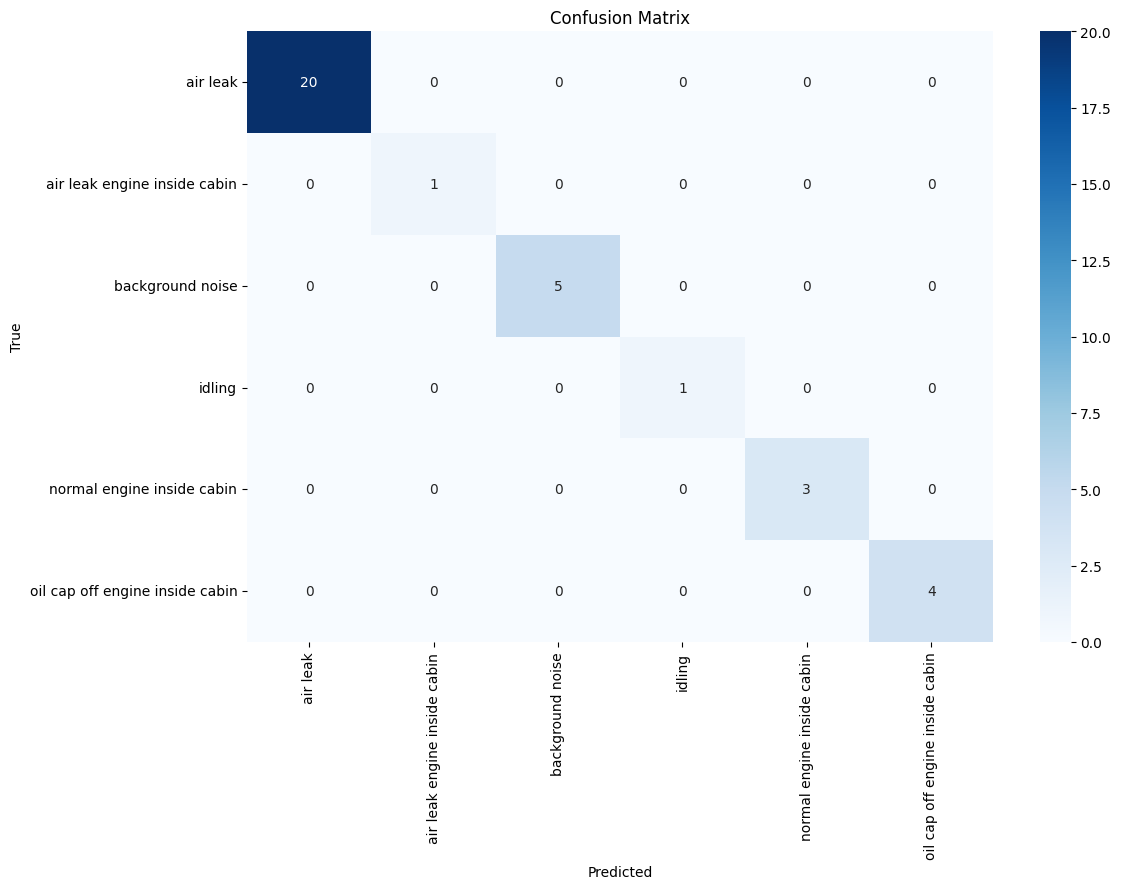

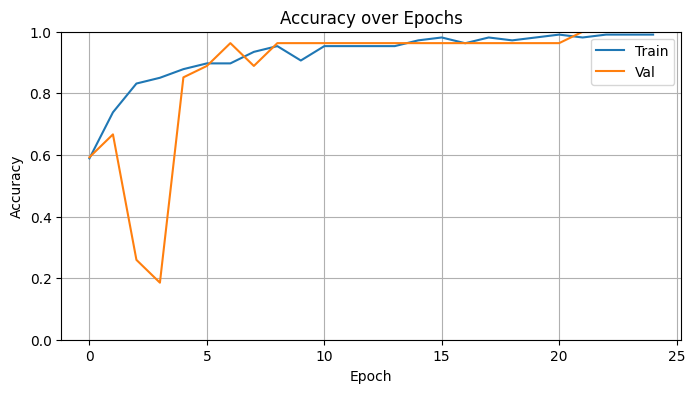

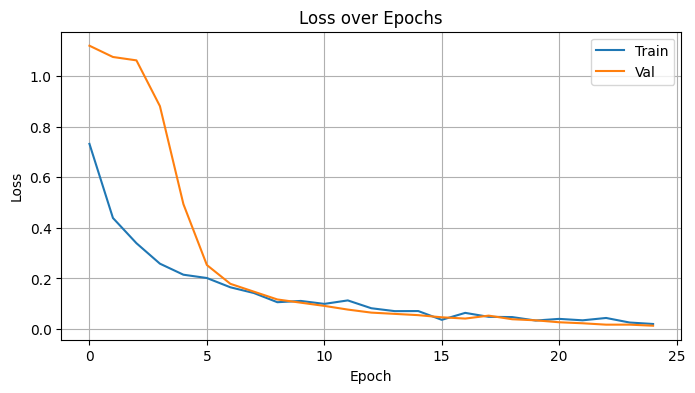

In [16]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

print("\nClassification Report:")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(12, 9))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d",
            cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrix_balanced.png")
plt.show()

# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # <-- Limite corretto per accuracy
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# **CNN con Reverse**

In [17]:
import os
import librosa
import pandas as pd
import numpy as np
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
INPUT_DIR = "/content/drive/MyDrive/audio_segmented"
OUTPUT_DIR = "/content/drive/MyDrive/audio_reverse"
CSV_OUTPUT = "/content/drive/MyDrive/df_with_reverse.csv"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# === Funzione: Estrai feature audio ===
def extract_features(y, sr):
    try:
        pitch = librosa.yin(y, fmin=80, fmax=800, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        energy = np.mean(y ** 2)
        inst_freq = librosa.piptrack(y=y, sr=sr)[0]

        return {
            "pitch_mean": np.mean(pitch),
            "pitch_std": np.std(pitch),
            "energy": energy,
            "zcr_mean": np.mean(zcr),
            "instant_freq_mean": np.mean(inst_freq)
        }
    except Exception as e:
        print("Errore nelle feature:", e)
        return None

# === Costruisci il DataFrame
records = []

for fname in tqdm(os.listdir(INPUT_DIR), desc="Processamento"):
    if not fname.endswith(".wav"):
        continue

    label = fname.split("__")[0]
    audio_path = os.path.join(INPUT_DIR, fname)

    try:
        y, sr = librosa.load(audio_path, sr=None)
    except Exception as e:
        print(f"Errore caricamento {fname}: {e}")
        continue

    # -- Originale
    feats = extract_features(y, sr)
    if feats:
        records.append({
            "audio_path": audio_path,
            "label": label,
            **feats,
            "augmented": False
        })

    # -- Reverse
    try:
        y_rev = y[::-1]
        rev_name = fname.replace(".wav", "_rev.wav")
        rev_path = os.path.join(OUTPUT_DIR, rev_name)
        sf.write(rev_path, y_rev, sr)

        feats_rev = extract_features(y_rev, sr)
        if feats_rev:
            records.append({
                "audio_path": rev_path,
                "label": label,
                **feats_rev,
                "augmented": True
            })
    except Exception as e:
        print(f"Errore salvataggio o feature reverse per {fname}: {e}")

# === Salva il CSV
df = pd.DataFrame(records)
df.to_csv(CSV_OUTPUT, index=False)

print(f"\nCSV salvato in: {CSV_OUTPUT}")
print(f"Totale righe: {len(df)}")
print(df.head())

Processamento: 100%|██████████| 223/223 [01:59<00:00,  1.86it/s]



CSV salvato in: /content/drive/MyDrive/df_with_reverse.csv
Totale righe: 446
                                          audio_path  \
0  /content/drive/MyDrive/audio_segmented/idling....   
1  /content/drive/MyDrive/audio_reverse/idling.2q...   
2  /content/drive/MyDrive/audio_segmented/idling....   
3  /content/drive/MyDrive/audio_reverse/idling.2q...   
4  /content/drive/MyDrive/audio_segmented/idling....   

                                               label  pitch_mean  pitch_std  \
0  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
1  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
2  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
3  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
4  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   

         energy  zcr_mean  instant_freq_mean  augmented  
0  5.960464e-08       0.0                0.0      Fa

In [18]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# === CONFIGURAZIONE ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/audio_reverse"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/audio_reverse/training_valid_audio_reverse"
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)

# === FUNZIONE: Verifica se un file audio è valido ===
def is_valid_audio(filepath, min_amplitude=0.01, min_duration=0.5):
    try:
        y, sr = librosa.load(filepath, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        max_amp = np.abs(y).max()
        return duration >= min_duration and max_amp >= min_amplitude
    except Exception as e:
        print(f"[Errore audio] {filepath}: {e}")
        return False

# === FUNZIONE: Crea spettrogramma mel e salva come PNG ===
def create_mel_spectrogram(audio_path, output_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        fig = plt.figure(figsize=(0.72, 0.72))
        ax = fig.add_subplot(111)
        ax.axis('off')
        librosa.display.specshow(S_dB, sr=sr)
        plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except Exception as e:
        print(f"[Errore spettrogramma] {audio_path}: {e}")

# === PROCESSO ===
audio_files = sorted([f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")])
valid_count, skipped_count = 0, 0

for fname in tqdm(audio_files, desc="Generazione PNG validi"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    png_name = fname.replace(".wav", ".png")
    png_path = os.path.join(OUTPUT_PNG_DIR, png_name)

    if not is_valid_audio(audio_path):
        skipped_count += 1
        continue

    create_mel_spectrogram(audio_path, png_path)
    valid_count += 1

print(f"\nPNG generati: {valid_count}")
print(f" File saltati (non validi): {skipped_count}")

Generazione PNG validi: 100%|██████████| 223/223 [01:07<00:00,  3.29it/s]


PNG generati: 98
 File saltati (non validi): 125


In [19]:
print(df.columns.tolist())

['audio_path', 'label', 'pitch_mean', 'pitch_std', 'energy', 'zcr_mean', 'instant_freq_mean', 'augmented']


In [20]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === CONFIG ===
csv_path = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
SPECTROGRAM_DIR = "/content/drive/MyDrive/audio_reverse/training_valid_audio_reverse"

# Carica CSV con le features
df = pd.read_csv(csv_path)

# Ricostruisci mappa label
label_map = dict(zip(df["label_encoded"], df["label"]))
records = []
all_pngs = os.listdir(SPECTROGRAM_DIR)

# Cerca i file *_segX_rev.png per ogni base audio
for _, row in df.iterrows():
    row_dict = row.to_dict()
    base_name = os.path.basename(row_dict["audio_path"]).replace(".wav", "")

    # Cerca match flessibile tipo: [base_name]_segX_rev.png
    matches = [f for f in all_pngs if f.startswith(base_name) and f.endswith("_rev.png")]

    for match in matches:
        rev_png_path = os.path.join(SPECTROGRAM_DIR, match)
        record = {
            "audio_path": row_dict["audio_path"],
            "spectrogram_path": rev_png_path,
            "label_encoded": row_dict["label_encoded"],
            "label": label_map[row_dict["label_encoded"]],
            "pitch_mean": row_dict["pitch_mean"],
            "pitch_std": row_dict["pitch_std"],
            "energy": row_dict["energy"],
            "zcr_mean": row_dict["zcr_mean"],
            "instant_freq_mean": row_dict["instant_freq_mean"]
        }
        records.append(record)

# DataFrame aggiornato
df_new = pd.DataFrame(records)

# Normalizzazione
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
if not df_new.empty:
    df_new[features] = StandardScaler().fit_transform(df_new[features])

#  Salva CSV
output_path = "/content/drive/MyDrive/features_combined_balanced_Reverse.csv"
df_new.to_csv(output_path, index=False)

print(f"CSV aggiornato salvato in: {output_path}")
print(f"Righe finali: {len(df_new)}")

CSV aggiornato salvato in: /content/drive/MyDrive/features_combined_balanced_Reverse.csv
Righe finali: 2632


In [21]:
import pandas as pd

# === Percorsi CSV ===
csv_normale = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
csv_reverse = "/content/drive/MyDrive/features_combined_balanced_Reverse.csv"

# === Carica entrambi ===
df_norm = pd.read_csv(csv_normale)
df_rev = pd.read_csv(csv_reverse)

# === Aggiungi colonna 'augmentation_type' ===
df_norm["augmentation_type"] = "original"
df_rev["augmentation_type"] = "reverse"

# === Verifica colonne compatibili (solo quelle rilevanti)
common_cols = ['audio_path', 'spectrogram_path', 'label', 'pitch_mean', 'pitch_std',
               'energy', 'zcr_mean', 'instant_freq_mean', 'label_encoded', 'augmentation_type']

df_norm = df_norm[common_cols]
df_rev = df_rev[common_cols]

# === Unisci
df_all = pd.concat([df_norm, df_rev], ignore_index=True)

# === Salva
final_path = "/content/drive/MyDrive/features_combined_balanced_final.csv"
df_all.to_csv(final_path, index=False)

print(f" Dataset completo salvato in: {final_path}")
print(f"Totale righe: {len(df_all)}")
print(df_all["augmentation_type"].value_counts())

 Dataset completo salvato in: /content/drive/MyDrive/features_combined_balanced_final.csv
Totale righe: 2800
augmentation_type
reverse     2632
original     168
Name: count, dtype: int64


In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Split

In [23]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

csv_path = "/content/drive/MyDrive/features_combined_balanced_final.csv"

# Carica dataset
full_df = pd.read_csv(csv_path)

# Fit LabelEncoder on the full dataset BEFORE splitting
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label'])

# Split stratificato
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df['label_encoded'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'], random_state=42)

# Salva CSV temporanei se vuoi
train_df.to_csv("/content/train.csv", index=False)
val_df.to_csv("/content/val.csv", index=False)
test_df.to_csv("/content/test.csv", index=False)

print(" Data split complete. Fitted LabelEncoder on the full dataset.")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

 Data split complete. Fitted LabelEncoder on the full dataset.
Train: 1960, Val: 420, Test: 420


In [24]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

# Carica i CSV in DataFrame
df_train = pd.read_csv("/content/train.csv")
df_val   = pd.read_csv("/content/val.csv")
df_test  = pd.read_csv("/content/test.csv")

# Trasformazioni per le immagini
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Crea i Dataset
train_ds = HybridAudioDataset(df_train, transform=transform)
val_ds   = HybridAudioDataset(df_val, transform=transform)
test_ds  = HybridAudioDataset(df_test, transform=transform)

# Crea i DataLoader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

print("DataLoader creati con successo.")

DataLoader creati con successo.


In [25]:
img, feat, label = next(iter(train_loader))
print(f"Immagine: {img.shape}")         # torch.Size([batch, 3, 64, 64])
print(f" Feature: {feat.shape}")        # torch.Size([batch, 5])
print(f"Label: {label.shape}")         # torch.Size([batch])

Immagine: torch.Size([16, 3, 64, 64])
 Feature: torch.Size([16, 5])
Label: torch.Size([16])


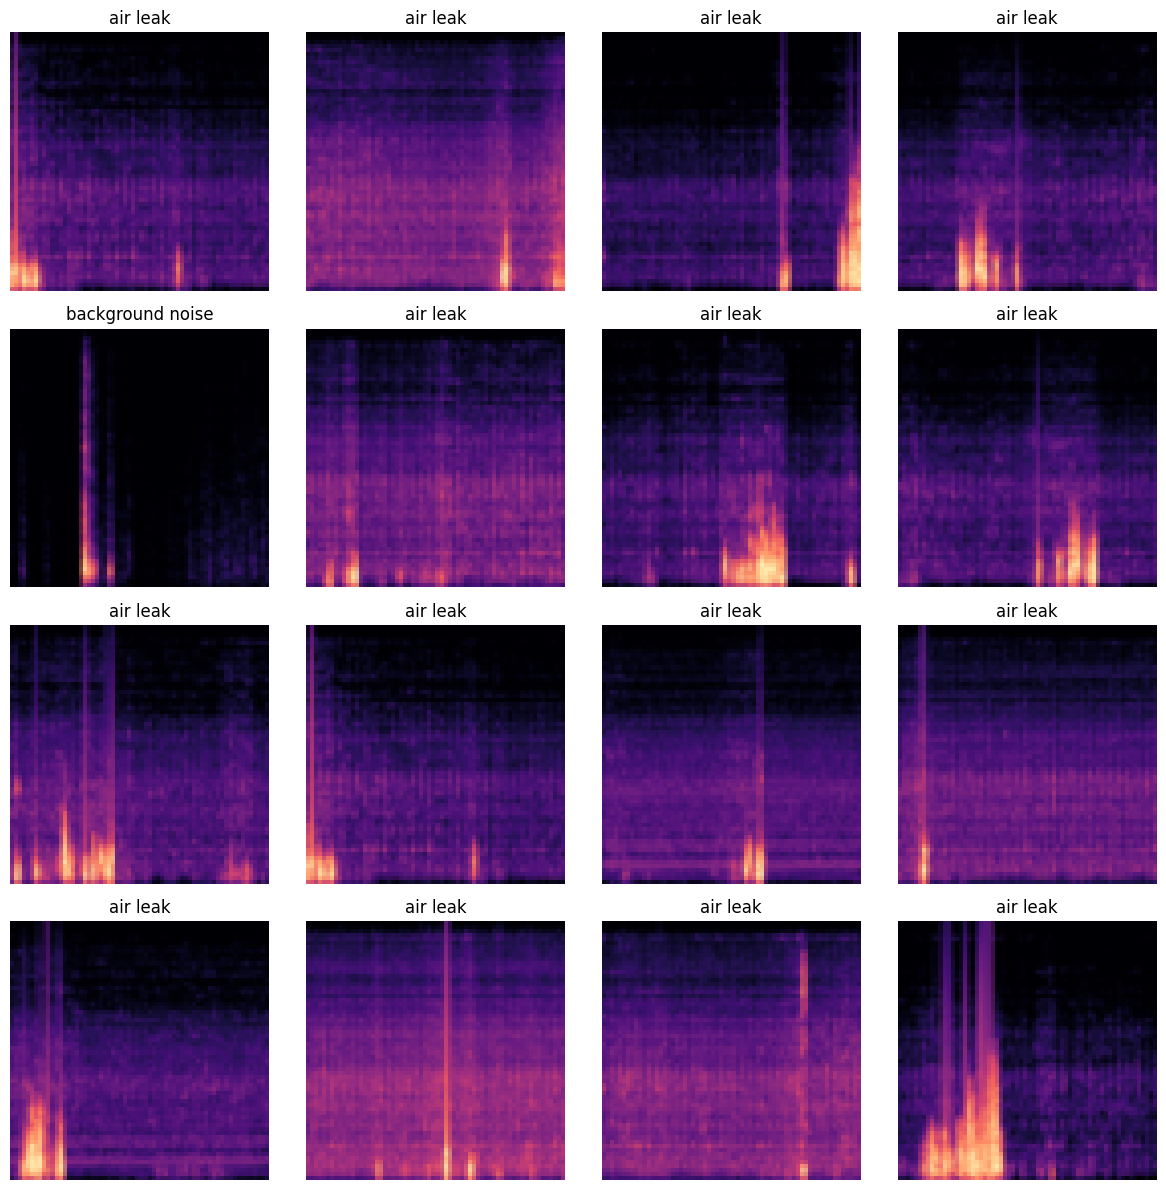

In [26]:
imgs, feats, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12)) # Adjusted figure size for 4x4 layout
for i in range(16):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    label_str = le.inverse_transform([labels[i].item()])[0]
    plt.subplot(4, 4, i+1) # Changed subplot layout to 4x4
    plt.imshow(img_np)
    plt.title(f"{label_str}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [27]:
class HybridCNNImproved(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNImproved, self).__init__()
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(5, 32), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*8*8 + 32, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.cnn_branch(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)



In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ==== Early Stopping ====
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [29]:
print(f"label_encoded min: {df['label_encoded'].min()}, max: {df['label_encoded'].max()}")
print(f"Numero classi da LabelEncoder: {len(le.classes_)}")
print("Classi da LabelEncoder:", list(le.classes_))



label_encoded min: 0, max: 5
Numero classi da LabelEncoder: 6
Classi da LabelEncoder: ['air leak', 'air leak engine inside cabin', 'background noise', 'idling', 'normal engine inside cabin', 'oil cap off engine inside cabin']


In [30]:
model = HybridCNNImproved(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStopping(patience=8)
EPOCHS = 10

In [31]:
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    running_train_loss, correct_train, total_train = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_acc.append(correct_train / total_train)
    train_loss.append(running_train_loss / total_train)

    # === VALIDATION ===
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in val_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc.append(correct_val / total_val)
    val_loss.append(running_val_loss / total_val)

    # === TEST ===
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc.append(correct_test / total_test)
    test_loss.append(running_test_loss / total_test)

    # === STAMPA ===
    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f} | "
          f"Test Acc: {test_acc[-1]:.2f}, Loss: {test_loss[-1]:.4f}")

    # === EARLY STOPPING ===
    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# === ULTIMA STAMPA FINALE (dopo stop) ===
print(f"\n Final Test Accuracy: {test_acc[-1]:.2f} | Loss: {test_loss[-1]:.4f}")


Epoch 001 | Train Acc: 0.93, Loss: 0.1506 | Val Acc: 0.97, Loss: 0.0462 | Test Acc: 0.97, Loss: 0.0405
Epoch 002 | Train Acc: 0.98, Loss: 0.0387 | Val Acc: 0.99, Loss: 0.0258 | Test Acc: 0.99, Loss: 0.0253
Epoch 003 | Train Acc: 0.99, Loss: 0.0267 | Val Acc: 1.00, Loss: 0.0168 | Test Acc: 0.99, Loss: 0.0189
Epoch 004 | Train Acc: 0.99, Loss: 0.0181 | Val Acc: 1.00, Loss: 0.0122 | Test Acc: 1.00, Loss: 0.0136
Epoch 005 | Train Acc: 0.99, Loss: 0.0136 | Val Acc: 1.00, Loss: 0.0058 | Test Acc: 1.00, Loss: 0.0075
Epoch 006 | Train Acc: 1.00, Loss: 0.0081 | Val Acc: 1.00, Loss: 0.0028 | Test Acc: 1.00, Loss: 0.0034
Epoch 007 | Train Acc: 1.00, Loss: 0.0046 | Val Acc: 1.00, Loss: 0.0013 | Test Acc: 1.00, Loss: 0.0018
Epoch 008 | Train Acc: 1.00, Loss: 0.0043 | Val Acc: 1.00, Loss: 0.0006 | Test Acc: 1.00, Loss: 0.0010
Epoch 009 | Train Acc: 1.00, Loss: 0.0027 | Val Acc: 1.00, Loss: 0.0004 | Test Acc: 1.00, Loss: 0.0005
Epoch 010 | Train Acc: 1.00, Loss: 0.0018 | Val Acc: 1.00, Loss: 0.0002 |


 Classification Report:
                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00       375
   air leak engine inside cabin       1.00      1.00      1.00         2
               background noise       1.00      1.00      1.00        24
                         idling       1.00      1.00      1.00         3
     normal engine inside cabin       1.00      1.00      1.00         7
oil cap off engine inside cabin       1.00      1.00      1.00         9

                       accuracy                           1.00       420
                      macro avg       1.00      1.00      1.00       420
                   weighted avg       1.00      1.00      1.00       420



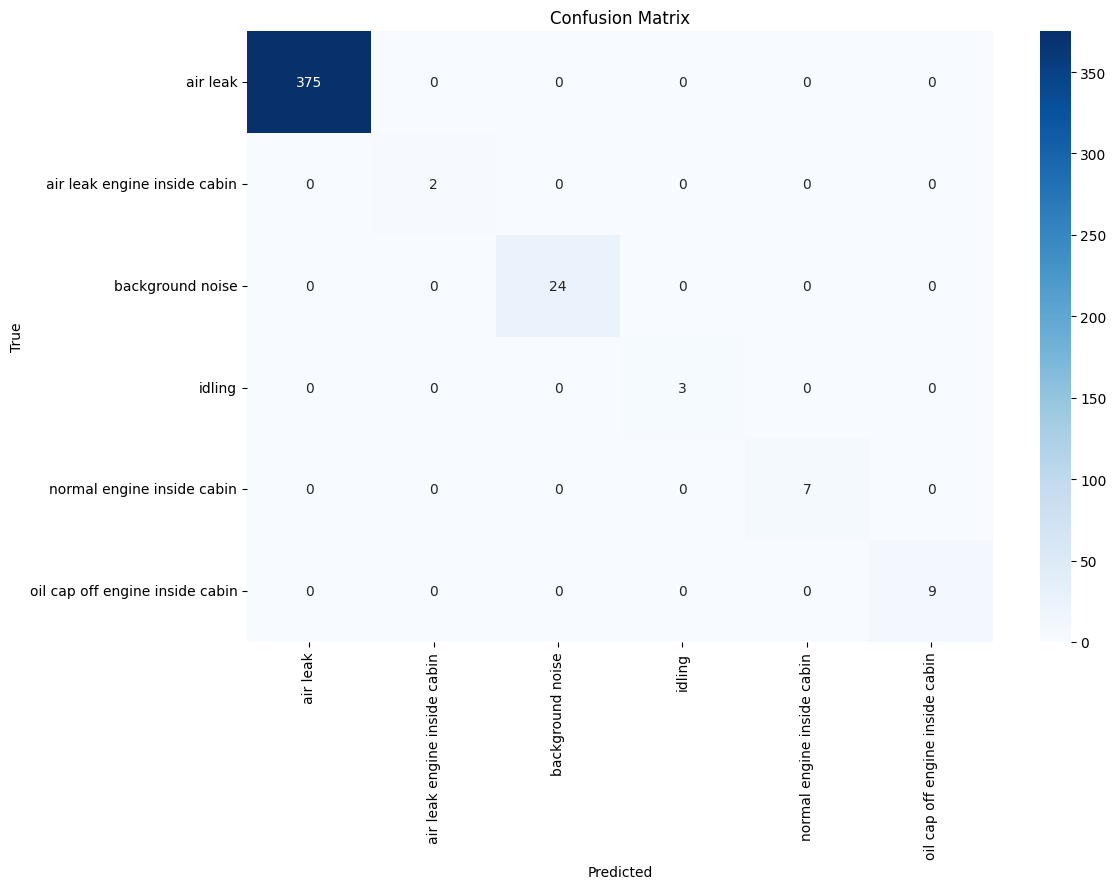

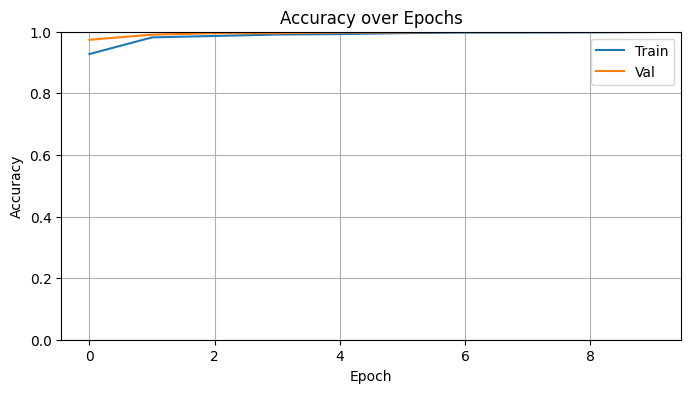

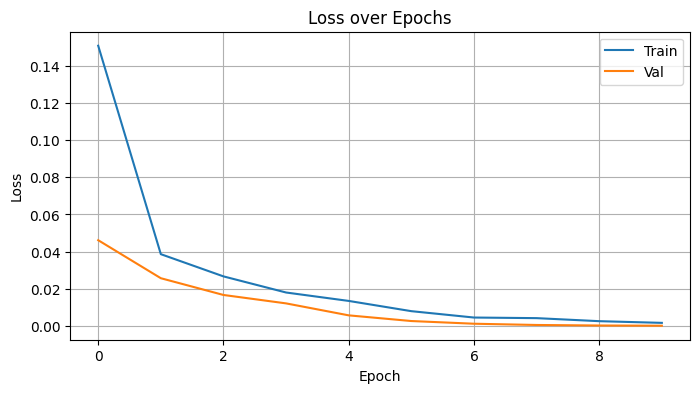

In [32]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

print("\n Classification Report:")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(12, 9))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d",
            cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrix_balanced_rev.png")
plt.show()

# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # <-- Limite corretto per accuracy
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

##  Modello ResNetHybrid

In [33]:
from torchvision import models
import torch.nn as nn

class ResNetHybrid(nn.Module):
    def __init__(self, num_classes):
        super(ResNetHybrid, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Rimuove classificatore finale
        self.feature_branch = nn.Sequential(nn.Linear(5, 64), nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.backbone(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetHybrid(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=8)

EPOCHS = 100
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc.append(correct / total)
    train_loss.append(running_loss / total)

    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc.append(correct / total)
    val_loss.append(running_loss / total)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f}")

    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# Carica il best model
model.load_state_dict(early_stopper.best_model)
print("Best model loaded.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Epoch 001 | Train Acc: 0.94, Loss: 0.0968 | Val Acc: 0.98, Loss: 0.0561
Epoch 002 | Train Acc: 0.95, Loss: 0.0849 | Val Acc: 0.98, Loss: 0.0353
Epoch 003 | Train Acc: 0.97, Loss: 0.0289 | Val Acc: 0.98, Loss: 0.0237
Epoch 004 | Train Acc: 0.98, Loss: 0.0216 | Val Acc: 0.98, Loss: 0.0199
Epoch 005 | Train Acc: 0.98, Loss: 0.0183 | Val Acc: 0.98, Loss: 0.0167
Epoch 006 | Train Acc: 0.98, Loss: 0.0162 | Val Acc: 0.98, Loss: 0.0154
Epoch 007 | Train Acc: 0.99, Loss: 0.0123 | Val Acc: 0.98, Loss: 0.0127
Epoch 008 | Train Acc: 0.98, Loss: 0.0189 | Val Acc: 0.98, Loss: 0.0113
Epoch 009 | Train Acc: 0.99, Loss: 0.0113 | Val Acc: 0.98, Loss: 0.0118
Epoch 010 | Train Acc: 0.98, Loss: 0.0118 | Val Acc: 0.98, Loss: 0.0103
Epoch 011 | Train Acc: 0.99, Loss: 0.0083 | Val Acc: 0.98, Loss: 0.0094
Epoch 012 | Train Acc: 0.99, Loss: 0.0090 | Val Acc: 0.98, Loss: 0.0077
Epoch 013 | Train Acc: 0.99, Loss: 0.0081 | Val Acc: 0.98, Loss: 0.0078
Epoch 014 | Train Acc: 0.99, Loss: 0.0072 | Val Acc: 0.99, Loss:

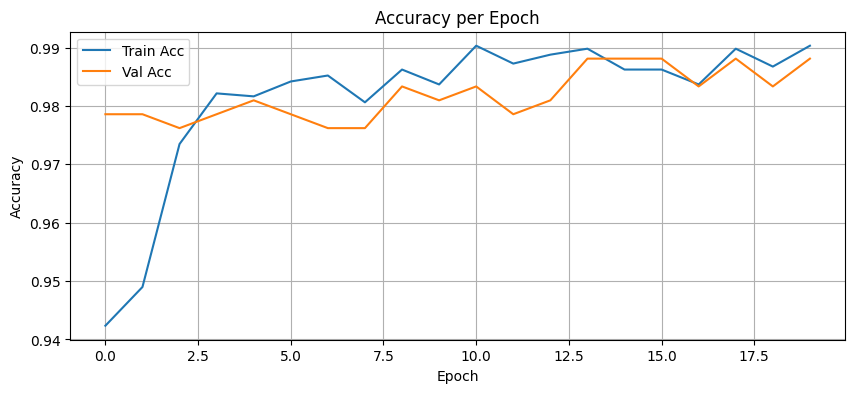

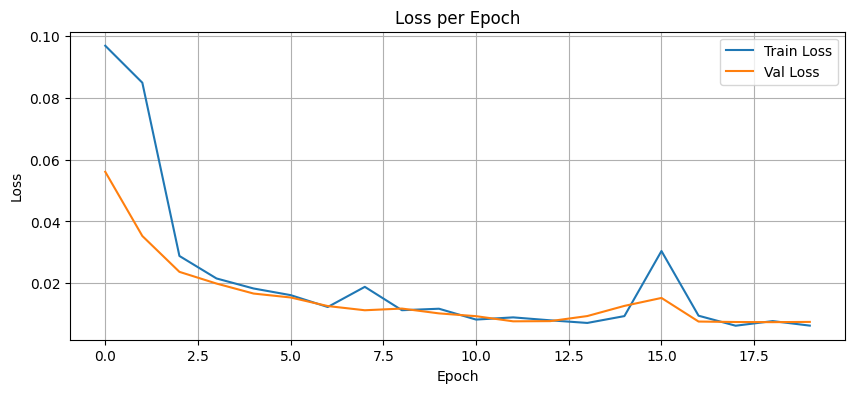

In [36]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

 Classification Report:

                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00       375
   air leak engine inside cabin       1.00      1.00      1.00         2
               background noise       1.00      1.00      1.00        24
                         idling       1.00      1.00      1.00         3
     normal engine inside cabin       1.00      0.29      0.44         7
oil cap off engine inside cabin       0.64      1.00      0.78         9

                       accuracy                           0.99       420
                      macro avg       0.94      0.88      0.87       420
                   weighted avg       0.99      0.99      0.99       420



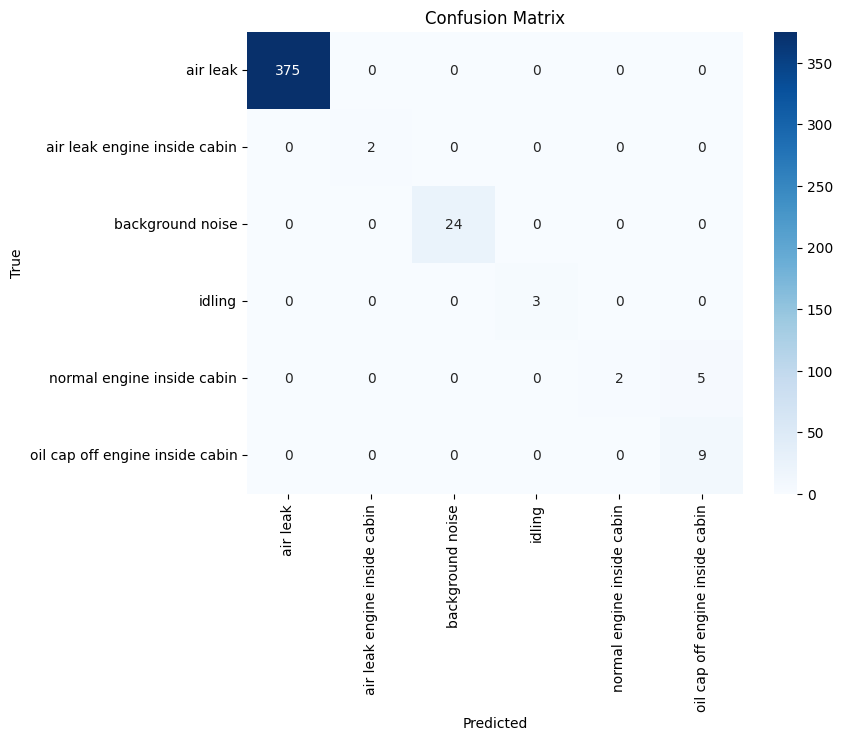

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Previsioni sul test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

# Classification report
print(" Classification Report:\n")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion matrix
plt.figure(figsize=(8, 6))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()